Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "" # put your full name here
COLLABORATORS = [] # list anyone you collaborated with on this workbook

---

## Lab 7: Gradient Descent and Resampling
**This lab was distributed Monday 10/14/2019 and should be completed by Monday 10/21/2019 at 11:59PM.**

Welcome to the seventh lab of the semester!

In this lab, we'll try minimizing L1 loss analytically, numerically, and through gradient descent. This gradient descent section is relevant to Homework 6, which was assigned last week. Since we didn't get a chance to practice gradient descent because we used lab 6 to learn Geopandas, this lab will give you some extra practice and guidance.

In the second part of the lab, we'll explore resampling (which is relevant to Homework 7, which will be assigned this Thursday). We will be learning about two methods of resampling: cross-validation and boostrapping.

### Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.simplefilter('ignore', FutureWarning) # Seaborn triggers warnings in scipy
%matplotlib inline

In [2]:
# Configure nice plotting defaults - (this must be done in a cell separate from %matplotlib call)
plt.style.use('seaborn')
sns.set_context('talk', font_scale=1)
plt.rcParams['figure.figsize'] = (10, 6)

### Section 1: Gradient Descent

#### The Data

In this section, we'll try fitting a simple linear regression. The data we're using comes from [California's urban water suppliers](https://data.ca.gov/dataset/drinking-water-public-water-system-operations-monthly-water-production-and-conservation-information). Run the cell below to load the data to dataframe `df`.

In [3]:
df = pd.read_csv("data/uw_supplier_data100319.csv")
df.head()

,Supplier_Name,PWSID,Stage_Invoked,Mandatory_Restrictions,Reporting_Month,Production_Reported,2013_Production_Reported,CII_Reported,Agriculture_Reported,2013_Agriculture_Reported,...,Percent_Residential_Use,Comments_Corrections,Hydrologic_Region,Watering_Days_Per_Week,Complaints,Follow_Ups,Warnings,Penalties_Rate,Penalties_Other,Enforcement_Comments
0,East Bay Municipal Utilities District,CA0110005,0,NaN,2019-08-15,6459.2,7172.3,1362.2,NaN,NaN,...,61.0,No Correction,San Francisco Bay,7.0,0,0,0,0,0,Although EBMUD is not currently implementing i...
1,East Bay Municipal Utilities District,CA0110005,0,NaN,2019-07-15,6317.4,7452.2,1172.0,NaN,NaN,...,60.0,No Correction,San Francisco Bay,7.0,0,0,0,0,0,Although EBMUD is not currently implementing i...
2,East Bay Municipal Utilities District,CA0110005,0,NaN,2019-06-15,5880.6,6927.5,901.0,NaN,NaN,...,61.0,No Correction,San Francisco Bay,7.0,0,0,0,0,0,Although EBMUD is not currently implementing i...
3,East Bay Municipal Utilities District,CA0110005,0,NaN,2019-05-15,5203.6,6716.5,819.0,NaN,NaN,...,60.0,No Correction,San Francisco Bay,7.0,0,0,0,0,0,Although EBMUD is not currently implementing i...
4,East Bay Municipal Utilities District,CA0110005,0,NaN,2019-04-15,4465.1,5417.5,757.0,NaN,NaN,...,62.0,No Correction,San Francisco Bay,7.0,0,0,0,0,0,Although EBMUD is not currently implementing i...


This data provides monthly reports of water production from urban water suppliers in California. We'll see how well we can predict "Production_Calculated" (production for a given month from a given water supplier, standardized to units of gallons of water, from 2014-2019) based on "2013_Production_Calculated" (production for that same month in 2013 from the same water supplier, standardized to units of gallons of water). Run the cell below to see what this relationship looks like.

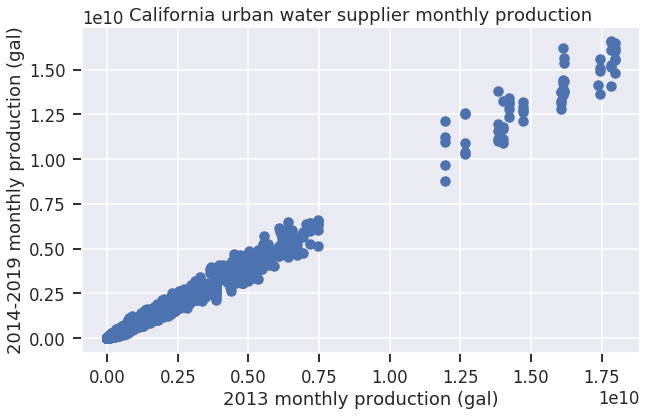

In [4]:
x = df["2013_Production_Calculated"]
y = df["Production_Calculated"]

plt.scatter(x,y)
plt.xlabel("2013 monthly production (gal)")
plt.ylabel("2014-2019 monthly production (gal)")
plt.title("California urban water supplier monthly production");

#### Absolute Loss (L1 Loss)

As we went over in lecture, average L1 loss takes in the absolute difference between each point and the prediction. 

It is defined as:
$\begin{aligned}L&= \frac{1}{n} \sum_{i = 1}^{n} |y_i − \hat{y}| \\\end{aligned}$

Absolute loss is known as L1 loss, and we will use those two terms interchangeably.

#### Question 1.1

Write `avg_abs_loss()` which takes in a set of predicted y values `y_hat` and a set of observed y values `y` and calculates average the absolute loss  (hint: there's a numpy function you'll probably find pretty handy).

In [6]:
# SOLUTION
def avg_absolute_loss(y_hat, y):
    return np.mean(np.abs(y_hat-y))

Run the following cell and check to make sure the computation makes sense.

In [7]:
y_test = np.array([5, 7, 8, 9])
y_hat_test = np.array([6, 9, 7, 6])
assert avg_absolute_loss(y_hat_test, y_test) == 1.75

#### Question 1.2

Let's visualize the absolute loss to get a better sense of what's happening. We're going to assume we have a linear model, with the form $\hat{y} = \theta_0 + \theta_1*x$. We'll start with the assumption that $\theta_0 = 0$, then plot the loss for different values of $\theta_1$. In the cell below, choose a range for $\theta_1$, then calculate the L1 loss for each $\theta_1$ and plot the L1 loss vs. $\theta_1$.

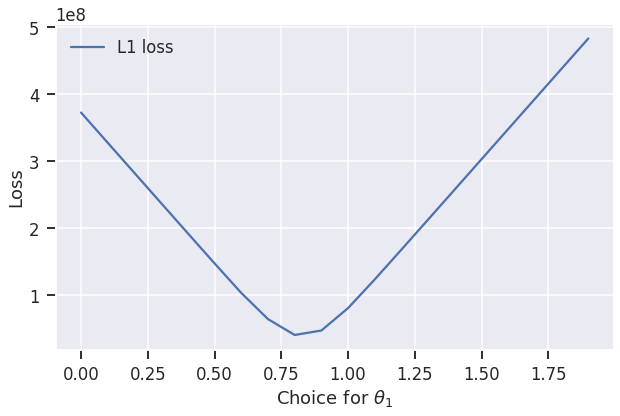

In [9]:
# SOLUTION
theta_0 = 0
theta_1 = np.arange(0,2,0.1)

loss = np.zeros(len(theta_1))

for i in range(len(theta_1)):
    loss[i] = avg_absolute_loss(theta_0 + theta_1[i]*x,y)

# plot the loss
plt.plot(theta_1, loss, label="L1 loss")
plt.xlabel(r"Choice for $\theta_1$")
plt.ylabel(r"Loss")
plt.legend();

Based on the plot, what value of theta minimizes our loss?

_YOUR ANSWER HERE_

#### Analytical Minimization

Now let's try to minimize the average L1 loss analytically.

In order to analytically find the theta that produces the $\hat{\theta}$, the $\theta$ that minimizes the L1 loss, we need to get the partial derivative with respect to $\theta$, that is $\frac{\partial}{\partial \theta} L(\theta, \textbf{y})$, and set it to zero. Unlike for L2 loss, we won't explicitly so
lve for $\theta$, and you’ll see why as you work through the problem.


Recall that the average L1 loss for our model is defined to be:
$\begin{aligned}L(\theta_1, \textbf{y})&= \frac{1}{n} \sum_{i = 1}^{n} |y_i − \theta_1*x| \\\end{aligned}$

#### Question 2.1

Find $\frac{\partial}{\partial \theta_1} L(\theta_1, \textbf{y})$ by hand and set it equal to zero. Show your work.

If you're having trouble writing it out in markdown, write it on a piece of paper, take a (legible) photo of it, upload it online, and hyperlink it in.

(We'll go through this all together as a lab, but if you get to this question early, you should try it out!)

_YOUR ANSWER HERE_

**Solution: (Maybe go over as class)**
$$\begin{aligned}
L(\theta_1, \textbf{y})
&= \frac{1}{n} \sum_{i = 1}^{n}|y_i − \theta_1*x_i|\\
&= \frac{1}{n} \left( \sum_{y_i < \theta_1*x_i}|y_i − \theta_1*x_i| + \sum_{y_i = \theta_1*x_i}|y_i − \theta_1*x_i| + \sum_{y_i > \theta_1*x_i}|y_i − \theta_1*x_i| \right)\\
&= \frac{1}{n} \left( \sum_{y_i < \theta_1*x_i}(\theta_1*x_i - y_i) + \sum_{y_i = \theta_1*x_i}(0) + \sum_{y_i > \theta_1*x_i}(y_i − \theta_1*x_i) \right)\\
\end{aligned}$$

$$\begin{aligned}
\frac{\partial}{\partial \theta_1} L(\theta_1, \textbf{y}) = \frac{1}{n} \left( \sum_{y_i < \theta_1*x_i}x_i + \sum_{y_i = \theta_1*x_i}0 + \sum_{y_i > \theta_1*x_i}−x_i \right) = 0\\
\end{aligned}$$

$$\begin{aligned}
\sum_{y_i < \theta_1*x_i}x_i = \sum_{y_i > \theta_1*x_i}x_i\\
\end{aligned}$$


#### Question 2.2
Why do we set the derivative equal to zero?

*YOUR ANSWER HERE*

**Question 2.3**
Based on your calculations in 2.1, you should have obtained $\sum_{y_i < \theta_1*x_i}x_i = \sum_{y_i > \theta_1*x_i} x_i$.<br>

Is there a way to solve for $\theta_1$ analytically - i.e. by finding $\theta_1$ as a function of $x$ and $y$, without guessing and checking different values of $\theta_1$?

(Don't spend more than ~5 minutes on this question! Think through some possible ways to calculate $\theta_1$ based on the formula. Would they be valid for any combination of $x$ and $y$?)

*YOUR ANSWER HERE*

**Question 2.4** Let's contrast our answer above with the analytical solution for a model of the form $\hat{y} = \theta$, where we're assuming our $y$ has a constant value. In this case, if we set $\frac{\partial}{\partial \theta} L(\theta, \textbf{y})$ to 0, we get:<br>

$\sum_{y_i < \theta}1 = \sum_{y_i > \theta}1$<br>

In this case, can we solve for $\theta$ analytically? If yes, explain how.

*YOUR ANSWER HERE*

**Solution:** 
On the left hand side, we get a sum for each data point that is less than $\theta$. On the right, we get a sum for each data point that is greater than $\theta$. Then, in order to satisfy the equation we need to pick a value for $\theta$ that has the same number of smaller and larger points. This is the definition for the median of a set of numbers. Thus, the minimizing value of $\theta$ for the L1 loss is $\hat\theta=median(y_i)$.

#### Gradient Descent

Sometimes, we cannot minimize loss functions analytically, especially when our models get more complex. And as we have seen in the previous section, brute force minimization by just trying out a bunch of different theta values and seeing which one returns the least loss is also incredibly inefficient. 

Instead, we use a technique called gradient descent, which is explained in [Ch.11 of the DS100 Textbook](https://www.textbook.ds100.org/ch/11/gradient_descent_define.html) and in Homework 6. To remind you of the intuition: the slope of the tangent line tells us which direction to move $\theta_1$ in order to decrease the loss. If the slope is negative, we want $\theta_1$ to move in the positive direction. If the slope is positive, $\theta_!$ should move in the negative direction. 

And mathematically, our formula is:

$$\theta^{(t+1)}_1 = \theta^{(t)}_1 − \alpha \cdot \frac{\partial}{\partial \theta_1} L(\theta^{(t)}_1, \textbf{y})$$

Where $ \theta^{(t)}_1$ is the current estimate, $ \theta^{(t+1)}_1$ is the next estimate, and $\alpha$ is the learning rate, or step size.


#### Question 4.1

Below is the partial derivative (gradient) of L1 loss, as calculated in 2.1. Using this formula, write a function that takes in a theta value and the observed data points, and returns the gradient of L1 loss at that theta. 

$$\begin{aligned}
\frac{\partial}{\partial \theta_1} L(\theta_1, \textbf{y})
&= \frac{1}{n} \left( \sum_{y_i < \theta_1*x_i}x_i - \sum_{y_i > \theta_1*x_i} x_i \right)\\
\end{aligned}$$

In [11]:
# SOLUTION
def grad_abs_loss(theta_1, x, y):
    x_greater = np.sum(x[x > (y/theta_1)])
    x_less = np.sum(x[x < (y/theta_1)])
    n = len(x)
    return (1/n)*(x_greater - x_less)

#### Question 4.2

Write a function called minimize, which continues to find a new theta until the thetas converge. You only need to fill in the parts to find the new theta using the mathematical formula for gradient descent:

$$\theta^{(t+1)}_1 = \theta^{(t)}_1 − \alpha \cdot \frac{\partial}{\partial \theta_1} L(\theta_1^{(t)}, \textbf{y})$$

In [16]:
# SOLUTION
def minimize(loss_fn, grad_loss_fn, x,y, alpha=1e-10, progress=True):
    '''
    Uses gradient descent to minimize loss_fn. Returns the minimizing value of
    theta_hat.
    '''
    theta = 0
    loss = np.array([])
    while True:
        if progress:
            print(f'theta: {theta:.2f} | loss: {loss_fn(theta*x, y):.2f}')
        loss = np.append(loss, loss_fn(theta*x,y))
        gradient = grad_loss_fn(theta, x,y)
        new_theta = theta - alpha * gradient
        
        if len(loss) - len(np.unique(loss)) >= 10:
            return new_theta
        
        theta = new_theta

Run the following cell to see `minimize()` iteratively print each step in gradient descent and to find the minimizing theta for our small toy dataset.

In [17]:
%%time
theta = minimize(avg_absolute_loss, grad_abs_loss, x,y)
print(f'Minimizing theta: {theta}')
print()

theta: 0.00 | loss: 372559507.81
theta: 0.05 | loss: 352276205.42
theta: 0.09 | loss: 331992903.04
theta: 0.14 | loss: 311709600.65
theta: 0.18 | loss: 291426298.26
theta: 0.23 | loss: 271142995.88
theta: 0.27 | loss: 250860199.22
theta: 0.32 | loss: 230583619.92
theta: 0.36 | loss: 210320998.34
theta: 0.41 | loss: 190077887.63
theta: 0.45 | loss: 169880203.85
theta: 0.50 | loss: 149758765.40
theta: 0.54 | loss: 129832633.80
theta: 0.58 | loss: 110350824.89
theta: 0.63 | loss: 91955538.36
theta: 0.67 | loss: 75591943.56
theta: 0.71 | loss: 62403004.64
theta: 0.74 | loss: 52636155.54
theta: 0.77 | loss: 46274680.82
theta: 0.79 | loss: 42546507.64
theta: 0.80 | loss: 40626708.66
theta: 0.81 | loss: 39702348.61
theta: 0.82 | loss: 39289332.65
theta: 0.82 | loss: 39111655.65
theta: 0.83 | loss: 39037643.68
theta: 0.83 | loss: 39007576.07
theta: 0.83 | loss: 38993940.46
theta: 0.83 | loss: 38986733.58
theta: 0.83 | loss: 38983500.06
theta: 0.83 | loss: 38981336.96
theta: 0.83 | loss: 389799

### Section 2: Resampling

Resampling is just what it sounds like - it involves repeatedly grabbing different samples of the data to train your model. We'll be exploring two methods here: cross-validation and boostrapping.

**Warm-up:** Bootstrapping is a way to estimate the error on the coefficients of your model. It involves dividing your data into $B$ groups of $n$ observations (where $n$ is your sample size), then calculating the model coefficients for each of those groups. In total, you'll have $B$ different models, called boostrap estimates. From there, you can find the standard error of your estimates. In boostrapping, your $n$ observations are sampled with replacement - that means that one observation will appear in multiple bootstrap groups, but it also means that one bootstrap group can include the same observation more than once. A good source for more information about bootstrapping is ISLR 5.2.<br>

Suppose that we obtain a bootstrap sample from a set of $n$ observations. When $n$ = 5, what is the probability that the jth observation is in the bootstrap sample? What about when $n$=100?

*Your answer here*

**Solution**: With bootsrapping, we're sampling with replacement. So when $n$ = 5, we have many possibilites for the bootstrap sample: it can contain one observation multiple times and/or a combination of observations. One way to calculate the probability is to see what the probability is that the $j^{th}$ element *won't* appear in the boostrap sample - that would mean that we selected the other 4 elements every time, or $(\frac{4}{5})^5$. The probability of the $j^{th}$ element appearing is then $1-(\frac{4}{5})^5 = 0.67$.

When $n$ = 100, the probability is $1-(\frac{99}{100})^{100} = 0.63$.

#### Cross-Validation

<img src='cv.png' width="50%" height="50%"></img>

Let's discuss what we see in the figure above. We are given a dataset to work with, and do our usual train-test split. We want to set aside the test data until we are absolutely ready to test the model we have created. However, in order to make sure that the model works as planned on data it is not 100% familiar with, we use cross-validation. In the image above, it is split into 4-folds. Essentially, each V that you see above represents a quarter of the training data set. This then acts as the test set, and the model is fitted on the remaining 3/4 of the train. This process is repeated three more times on different subsets, and the average MSE indicates the total validity of the algorithm on the "unseen" data.

----

To gain a little more intuition about cross-validation, we're going to work with the Boston Housing dataset, which concerns the housing values in the suburbs of Boston. We'll be using two features: `NOX`, the nitrogen oxides concentrations (in ppm) and `LSTAT`, the lower status of the population to predict the `target` column, the median value of owner-occupied homes (in thousands of dollars). Run the following cells to load the data and visualize the two features we'll be working with. 

In [16]:
cv_data = pd.read_csv('data/boston_housing.csv')
cv_data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


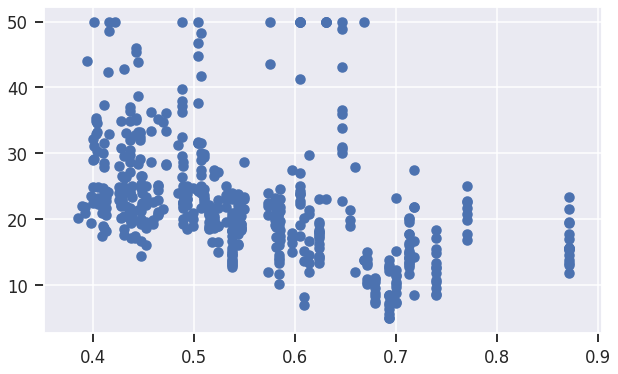

In [17]:
plt.scatter(cv_data.NOX, cv_data.target);

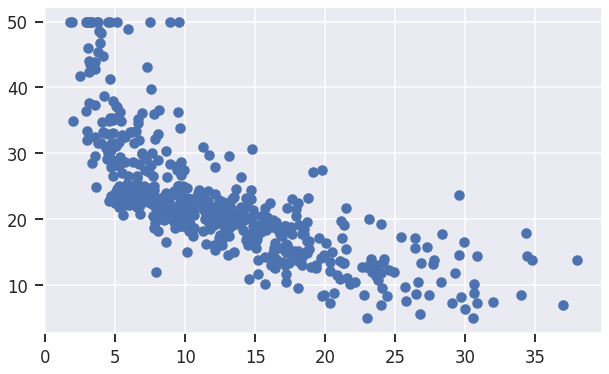

In [18]:
plt.scatter(cv_data.LSTAT, cv_data.target);

We'll focus on Leave-One-Out Cross Validation (LOOCV), which involves splitting the set of training observations into two parts: a single observation $(x_i, y_i)$ is used for the validation set, and the rest are used for the training set. 

**Question 2.1**

What is a drawback with using only one observation for the validation set? Would LOOCV have much utility when splitting large datasets? Explain.

*Your answer here*

We'll use scikit-learn's `LeaveOneOut` function to split our dataset. Let's start by splitting our data into training and testing sets. 

**Question 2.2** 

Split the dataset, using `NOX` and `LSTAT` as our features and `target` as what we're predicting. Don't forget the intercept! Set `test_size` to .25 and `random_state` to 2. Here, we'll use the [train_test_split() function](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

In [20]:
# SOLUTION 
from sklearn.model_selection import train_test_split
    
cv_data['intercept'] =  np.ones(cv_data.shape[0])
X = cv_data[['NOX', 'LSTAT', 'intercept']]
y = cv_data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state=2)

Before we continue, let's review the arguments for `train_test_split`.

**Question 2.3** How do the parameters `test_size` and `random_state` affect the data we work with? How would a higher or lower value for `test_size` affect our results?

*Your answer here*

Now, let's fit the model with our training data.

**Question 2.4** Instantiate a `LinearRegression` model and fit the training data. Then, predict the `target` variable using the test set. Lastly, print the $R^2$ score as well as the MSE of the fitted model (we're not going to do LOOCV quite yet - first we'll try the method we've been using so far, of fitting the training data and testing the model on testing data). Here, we're introducing two new sklearn functions: [r2_score()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html) and [mean_squared_error()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html).

In [22]:
# SOLUTION 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

lm = LinearRegression()
lm.fit(X_train, y_train)
predictions = lm.predict(X_test)
predictions[:5]

print('R^2: ', r2_score(y_test, predictions))
print('MSE: ', mean_squared_error(y_test, predictions))

R^2:  0.5791715631247535
MSE:  37.34912100517363


With the scores, we have a baseline to compare a cross-validated score with. Run the following cell to perform LOOCV and check what happens to the $R^2$ score and MSE.

In [23]:
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()
loo.get_n_splits(X)
y_tests = []
y_predictions = []
for train, test in loo.split(X):
    Xr_train, Xr_test = np.array(X)[train], np.array(X)[test]
    yr_train, yr_test = np.array(y)[train], np.array(y)[test]
    
    lr = LinearRegression()
    lr.fit(Xr_train, yr_train)
    yr_pred = lr.predict(Xr_test)
    
    y_tests.append(yr_test)
    y_predictions.append(yr_pred)

r2_loo = r2_score(y_tests, y_predictions)
MSE_loo = mean_squared_error(y_tests, y_predictions)
print("R^2 after LOOCV: ", r2_loo)
print("MSE after LOOCV: ", MSE_loo)

R^2 after LOOCV:  0.5368514224747057
MSE after LOOCV:  39.09879734904477


**Question 2.5** How does the $R^2$ score and MSE change when we do LOOCV?

*Your answer here*

**Question 2.6** Let's try one more experiment in comparing a simple training-testing approach with LOOCV. When we tried dividing the data into training and testing data, we chose `random_state = 2` so that we would all end up with the same training and testing sets. Let's try varying `random_state` and seeing how the resulting $R^2$ and MSE compare to the metrics obtained when did LOOCV. Fill in the ... below, and then run the cells below that to generate a plot that shows the distribution of MSE and $R^2$ values using the training-testing sets with the value from LOOCV displayed as a vertical line.

In [25]:
ntrial = 100

r2 = []
MSE = []

for i in range(0,ntrial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state=i)
    
    lm = LinearRegression()
    lm.fit(X_train, y_train)
    predictions = lm.predict(X_test)

    r2.append(r2_score(y_test, predictions))
    MSE.append(mean_squared_error(y_test, predictions))

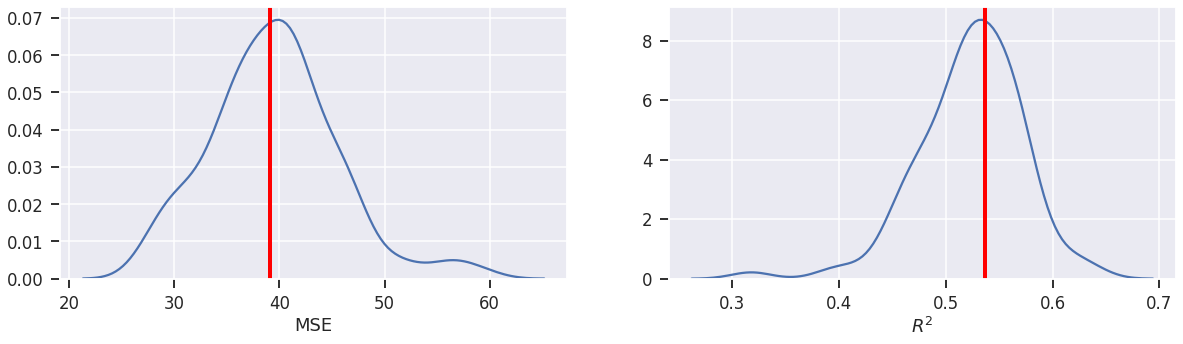

In [26]:
# run this cell
plt.figure(figsize = (20,5))

plt.subplot(121)
sns.kdeplot(MSE)
plt.axvline(x = MSE_loo, linewidth=4, color='r')
plt.xlabel("MSE")

plt.subplot(122)
sns.kdeplot(r2)
plt.axvline(x = r2_loo, linewidth=4, color='r')
plt.xlabel("$R^2$");

**Question 2.7** Where does the MSE and $R^2$ value from LOOCV sit relative to the distribution of values from the randomized training-testing approach? Does this result make sense to you given what you know about LOOCV? Why or why not?

*Your answer here*

### Bibliography
- DS100 - “Gradient Descent” - https://www.textbook.ds100.org/ch/11/gradient_descent_define.html 
- DS100 - “Absolute Loss” - https://www.textbook.ds100.org/ch/10/modeling_abs_huber.html
- DS100 - “Models and Estimation” - http://www.ds100.org/fa18/assets/lectures/lec09/09-Models-and-Estimation-II.html 

---
Notebook developed by: Joshua Asuncion, Rebekah Tang

Data Science Modules: http://data.berkeley.edu/education/modules
